In [ ]:
## read in midi data for ground truth 

In [1]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import colorConverter
#import keras

# inherit the origin mido class
class MidiFile(mido.MidiFile):

    def __init__(self, filename):

        mido.MidiFile.__init__(self, filename)
        self.sr = 43
        self.meta = {}
        self.events = self.get_events()

    def get_events(self):
        mid = self

        # There is > 16 channel in midi.tracks. However there is only 16 channel related to "music" events.
        # We store music events of 16 channel in the list "events" with form [[ch1],[ch2]....[ch16]]
        # Lyrics and meta data used a extra channel which is not include in "events"

        events = [[] for x in range(16)]

        # Iterate all event in the midi and extract to 16 channel form
        for track in mid.tracks:
            for msg in track:
                try:
                    channel = msg.channel
                    events[channel].append(msg)
                except AttributeError:
                    try:
                        if type(msg) != type(mido.UnknownMetaMessage):
                            self.meta[msg.type] = msg.dict()
                        else:
                            pass
                    except:
                        print("error",type(msg))

        return events

    def get_roll(self):
        events = self.get_events()
        # Identify events, then translate to piano roll
        # choose a sample ratio(sr) to down-sample through time axis
        sr = self.sr

        # compute total length in tick unit
        length = self.get_total_ticks()

        # allocate memory to numpy array
        roll = np.zeros((16, 192, length // sr), dtype="int8")

        # use a register array to save the state(no/off) for each key
        note_register = [int(-1) for x in range(192)]

        # use a register array to save the state(program_change) for each channel
        timbre_register = [1 for x in range(16)]


        for idx, channel in enumerate(events):

            time_counter = 0
            volume = 100
            # Volume would change by control change event (cc) cc7 & cc11
            # Volume 0-100 is mapped to 0-127

            for msg in channel:
                if msg.type == "control_change":
                    if msg.control == 7:
                        volume = msg.value
                        # directly assign volume
                    if msg.control == 11:
                        volume = volume * msg.value // 127
                        # change volume by percentage

                if msg.type == "program_change":
                    timbre_register[idx] = msg.program



                if msg.type == "note_on":
                    note_on_start_time = time_counter // sr
                    note_on_end_time = (time_counter + msg.time) // sr
                    intensity = volume * msg.velocity // 127



					# When a note_on event *ends* the note start to be play 
					# Record end time of note_on event if there is no value in register
					# When note_off event happens, we fill in the color
                    if note_register[msg.note] == -1:
                        note_register[msg.note] = (note_on_end_time,intensity)
                    else:
					# When note_on event happens again, we also fill in the color
                        old_end_time = note_register[msg.note][0]
                        old_intensity = note_register[msg.note][1]
                        roll[idx, msg.note, old_end_time: note_on_end_time] = old_intensity
                        note_register[msg.note] = (note_on_end_time,intensity)


                if msg.type == "note_off":
                    note_off_start_time = time_counter // sr
                    note_off_end_time = (time_counter + msg.time) // sr
                    if note_register[msg.note] == -1:
                        note_on_end_time = 1
                        intensity = 59
                    else:
                        note_on_end_time = note_register[msg.note][0]
                        intensity = note_register[msg.note][1]
					# fill in color
                    roll[idx, msg.note, note_on_end_time:note_off_end_time] = intensity

                    note_register[msg.note] = -1  # reinitialize register

                time_counter += msg.time

                # TODO : velocity -> done, but not verified
                # TODO: Pitch wheel
                # TODO: Channel - > Program Changed / Timbre catagory
                # TODO: real time scale of roll

            # if there is a note not closed at the end of a channel, close it
            for key, data in enumerate(note_register):
                if data != -1:
                    note_on_end_time = data[0]
                    intensity = data[1]
                    # print(key, note_on_end_time)
                    note_off_start_time = time_counter // sr
                    roll[idx, key, note_on_end_time:] = intensity
                note_register[idx] = -1

        return roll

    def get_roll_image(self):
        roll = self.get_roll()
        plt.ioff()

        K = 16

        transparent = colorConverter.to_rgba('black')
        colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / K, 1, 1)), alpha=1) for i in range(K)]
        cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, colors[i]], 192) for i in
                 range(K)]

        for i in range(K):
            cmaps[i]._init()  # create the _lut array, with rgba values
            # create your alpha array and fill the colormap with them.
            # here it is progressive, but you can create whathever you want
            alphas = np.linspace(0, 1, cmaps[i].N + 3)
            cmaps[i]._lut[:, -1] = alphas

        fig = plt.figure(figsize=(4, 3))
        a1 = fig.add_subplot(111)
        a1.axis("equal")
        a1.set_facecolor("black")

        array = []

        for i in range(K):
            try:
                img = a1.imshow(roll[i], interpolation='nearest', cmap=cmaps[i], aspect='auto')
                array.append(img.get_array())
            except IndexError:
                pass
        return array

    def draw_roll(self):


        roll = self.get_roll()

        # build and set fig obj
        plt.ioff()
        fig = plt.figure(figsize=(4, 3))
        a1 = fig.add_subplot(111)
        a1.axis("equal")
        a1.set_facecolor("black")

        # change unit of time axis from tick to second
        tick = self.get_total_ticks()
        second = mido.tick2second(tick, self.ticks_per_beat, self.get_tempo())
        if second > 10:
            x_label_period_sec = second // 10
        else:
            x_label_period_sec = second / 10  # ms
        x_label_interval = mido.second2tick(x_label_period_sec, self.ticks_per_beat, self.get_tempo()) / self.sr
        plt.xticks([int(x * x_label_interval) for x in range(20)], [round(x * x_label_period_sec, 2) for x in range(20)])

        # change scale and label of y axis
        plt.yticks([y*16 for y in range(8)], [y*16 for y in range(8)])

        # build colors
        channel_nb = 16
        transparent = colorConverter.to_rgba('black')
        colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / channel_nb, 1, 1)), alpha=1) for i in range(channel_nb)]
        cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, colors[i]], 192) for i in
                 range(channel_nb)]

        # build color maps
        for i in range(channel_nb):
            cmaps[i]._init()
            # create your alpha array and fill the colormap with them.
            alphas = np.linspace(0, 1, cmaps[i].N + 3)
            # create the _lut array, with rgba values
            cmaps[i]._lut[:, -1] = alphas


        # draw piano roll and stack image on a1
        for i in range(channel_nb):
            try:
                a1.imshow(roll[i], origin="lower", interpolation='nearest', cmap=cmaps[i], aspect='auto')
            except IndexError:
                pass

        # draw color bar

        colors = [mpl.colors.hsv_to_rgb((i / channel_nb, 1, 1)) for i in range(channel_nb)]
        cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', colors, 16)
        a2 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
        cbar = mpl.colorbar.ColorbarBase(a2, cmap=cmap,
                                        orientation='horizontal',
                                        ticks=list(range(16)))

        # show piano roll
        plt.draw()
        plt.ion()
        plt.show(block=True)

    def get_tempo(self):
        try:
            return self.meta["set_tempo"]["tempo"]
        except:
            return 500000

    def get_total_ticks(self):
        max_ticks = 0
        for channel in range(16):
            ticks = sum(msg.time for msg in self.events[channel])
            if ticks > max_ticks:
                max_ticks = ticks
        return max_ticks

In [2]:
import csv
import os 


midi_files = []
directory = r'midi-visualization-master'
for filename in os.listdir(directory):
    if filename.endswith(".mid"):
        midi_files.append(filename)
    else:
        continue
        
print(midi_files)

['funk_autumnleaves_108BPM_Eb_comp.mid', 'funk_autumnleaves_108BPM_Eb_solo.mid', 'funk_autumnleaves_119BPM_G_comp.mid', 'funk_autumnleaves_119BPM_G_solo.mid', 'funk_blues_114BPM_Ab_comp.mid', 'funk_blues_114BPM_Ab_solo.mid', 'funk_blues_97BPM_C_comp.mid', 'funk_blues_97BPM_C_solo.mid', 'funk_pachelbel_112BPM_C#_comp.mid', 'funk_pachelbel_112BPM_C#_solo.mid', 'funk_pachelbel_98BPM_A_comp.mid', 'funk_pachelbel_98BPM_A_solo.mid', 'jazz_autumnleaves_110BPM_Bb_comp.mid', 'jazz_autumnleaves_110BPM_Bb_solo.mid', 'jazz_autumnleaves_187BPM_F#_comp.mid', 'jazz_autumnleaves_187BPM_F#_solo.mid', 'jazz_blues_130BPM_D_comp.mid', 'jazz_blues_130BPM_D_solo.mid', 'jazz_blues_200BPM_B_comp.mid', 'jazz_blues_200BPM_B_solo.mid', 'jazz_pachelbel_110BPM_Eb_comp.mid', 'jazz_pachelbel_110BPM_Eb_solo.mid', 'jazz_pachelbel_150BPM_C_comp.mid', 'jazz_pachelbel_150BPM_C_solo.mid', 'rock_autumnleaves_142BPM_D_comp.mid', 'rock_autumnleaves_142BPM_D_solo.mid', 'rock_autumnleaves_85BPM_F_comp.mid', 'rock_autumnleaves_

In [3]:
rolls = []
for filename in midi_files:
    mid = MidiFile(r"midi-visualization-master\\%s" % filename)
    
    # get the list of all events

    # get the np array of piano roll image
    roll = mid.get_roll()
    rolls.append(roll)

(16, 192, 357)
(16, 192, 357)
(16, 192, 354)
(16, 192, 323)
(16, 192, 446)
(16, 192, 446)
(16, 192, 446)
(16, 192, 438)
(16, 192, 379)
(16, 192, 368)
(16, 192, 357)
(16, 192, 368)
(16, 192, 351)
(16, 192, 353)
(16, 192, 312)
(16, 192, 357)
(16, 192, 357)
(16, 192, 357)
(16, 192, 893)
(16, 192, 870)
(16, 192, 357)
(16, 192, 357)
(16, 192, 357)
(16, 192, 401)
(16, 192, 353)
(16, 192, 357)
(16, 192, 357)
(16, 192, 357)
(16, 192, 535)
(16, 192, 535)
(16, 192, 446)
(16, 192, 401)
(16, 192, 357)
(16, 192, 357)
(16, 192, 357)
(16, 192, 357)
(16, 192, 357)
(16, 192, 357)
(16, 192, 357)
(16, 192, 357)
(16, 192, 267)
(16, 192, 259)
(16, 192, 267)
(16, 192, 267)
(16, 192, 178)
(16, 192, 189)
(16, 192, 178)
(16, 192, 223)


In [4]:
coords = []
for r in range(len(rolls)):
    temp = []
    for i in range(len(rolls[r][0])):
        for j in range(len(rolls[r][0][i])):
            if(rolls[r][0][i][j]==59):
                temp.append((i,j))
    coords.append(temp)

In [5]:
test = []
for i in range(0,48):
    test.append([0])
test

for c in range(0,48):
    maxvalue = max([j for i,j in coords[c]])
    temp = []
    for i in range(0,maxvalue):
        notes = []
        for j,k in coords[c]:
            if k == i:
                notes.append(j)
        temp.append(notes)
    test[c] = temp

In [6]:
openstringvalues = [39, 44, 49, 54, 58, 63]
midinotes = []
for i in test:
    temp = []
    for j in i:
        notes = np.zeros((6,21))
        for k in j:
            for l in range(len(openstringvalues)):
                if k-openstringvalues[l] < 20 and k-openstringvalues[l]>=0:
                    notes[l][k-openstringvalues[l]] = 1
                else:
                    notes[l][-1] = 1
        temp.append(notes.tolist())
    midinotes.append(np.array(temp))

In [7]:
midinotes[0].shape

(356, 6, 21)

In [8]:
midilengths = []
for i in range(len(midinotes)):
    midilengths.append(midinotes[i].shape[0])

In [9]:
##Metrics

In [10]:
def tab2pitch(tab):
    pitch_vector = np.zeros(44)
    string_pitches = [40, 45, 50, 55, 59, 64]
    for string_num in range(len(tab)):
        fret_vector = tab[string_num]
        fret_class = np.argmax(fret_vector, -1)
        if fret_class < 21:
            pitch_num = fret_class + string_pitches[string_num] - 41
            pitch_vector[pitch_num] = 1
    return pitch_vector

def tab2bin(tab):
    tab_arr = np.zeros((6,21))
    for string_num in range(len(tab)):
        fret_vector = tab[string_num]
        fret_class = np.argmax(fret_vector, -1)
        if fret_class < 21:
            fret_num = fret_class - 1
            tab_arr[string_num][fret_num] = 1
        #print(tab_arr)
    return tab_arr

def pitch_precision(pred, gt):
    pitch_pred = np.array(list(map(tab2pitch,pred)))
    pitch_gt = np.array(list(map(tab2pitch,gt)))
    numerator = np.sum(np.multiply(pitch_pred, pitch_gt).flatten())
    denominator = np.sum(pitch_pred.flatten())
    return (1.0 * numerator) / denominator

def pitch_recall(pred, gt):
    pitch_pred = np.array(list(map(tab2pitch,pred)))
    pitch_gt = np.array(list(map(tab2pitch,gt)))
    numerator = np.sum(np.multiply(pitch_pred, pitch_gt).flatten())
    denominator = np.sum(pitch_gt.flatten())
    return (1.0 * numerator) / denominator

def pitch_f_measure(pred, gt):
    p = pitch_precision(pred, gt)
    r = pitch_recall(pred, gt)
    f = (2 * p * r) / (p + r + 0.0001)
    return f

def tab_precision(pred, gt):
    # get rid of "closed" class, as we only want to count positives
    tab_pred = np.array(list(map(tab2bin,pred)))
    tab_gt = np.array(list(map(tab2bin,gt)))
    numerator = np.sum(np.multiply(tab_pred, tab_gt).flatten())
    denominator = np.sum(tab_pred.flatten())
    return (1.0 * numerator) / denominator

def tab_recall(pred, gt):
    # get rid of "closed" class, as we only want to count positives
    tab_pred = np.array(list(map(tab2bin,pred)))
    tab_gt = np.array(list(map(tab2bin,gt)))
    numerator = np.sum(np.multiply(tab_pred, tab_gt).flatten())
    denominator = np.sum(tab_gt.flatten())
    return (1.0 * numerator) / denominator

def tab_f_measure(pred, gt):
    p = tab_precision(pred, gt)
    r = tab_recall(pred, gt)
    f = (2 * p * r) / (p + r + 0.0001)
    return f

def tab_disamb(pred, gt):
    tp = tab_precision(pred, gt)
    print(tp)
    pp = pitch_precision(pred, gt)
    print(pp+0.0001)
    return tp / (pp + 0.0001)


In [11]:
#reading cqts

In [12]:
import librosa
import librosa.display
import soundfile as sf

cqtlist = []
lengths = []

for filename in os.listdir(r'tracks'):
    if filename.endswith(".wav"):

        file = r"tracks\%s" % filename
        y, sr = sf.read(file)
        y = y[0:len(y),0]

        C = np.abs(librosa.cqt(y=y,n_bins=192,bins_per_octave=24,sr=44100))
        C = np.swapaxes(C,0,1)
        cqtlist.append(C)
        lengths.append(len(y))

In [13]:
res_cqts = []
for C in cqtlist:
    index = 0
    for c in range(len(C)-1,-1,-1):
        if max(C[c]) != 0:
            index = c
            break
    C = C[0:index]
    res_cqts.append(C)

In [14]:
from skimage import data, color
from skimage.transform import rescale, resize

res_imgs = []
for i in range(len(res_cqts)):
    index = 0
    for c in range(len(C)-1,-1,-1):
        if max(C[c]) != 0:
            index = c
            break
    C = C[0:index]
    image_resized = resize(C, (midilengths[i], 192),
                          anti_aliasing=True)
    res_imgs.append(image_resized)

In [15]:
inputs = []
for i in range(len(res_imgs)):
    Xs = []
    full_x = np.pad(res_imgs[i], [((9 // 2),(9 // 2)), (0,0)], mode='constant')
    for i in range(0,len(res_imgs[i]-1)):
        frame_idx = i 
        sample_x = full_x[frame_idx : frame_idx + 9]
        X = np.expand_dims(np.swapaxes(sample_x, 0, 1), -1)
        Xs.append(X)
    Xs = np.array(Xs)
    inputs.append(Xs)

In [16]:
inputs[0].shape

(356, 192, 9, 1)

In [17]:
midilengths[0]

356

In [18]:
from __future__ import print_function
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv2D, MaxPooling2D, Conv1D, Lambda
from keras import backend as K
import pandas as pd
import numpy as np
import datetime
import mido
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import colorConverter
import keras
class TabCNN:
    
    def __init__(self, 
                 batch_size=128, 
                 epochs=8,
                 con_win_size = 9,
                 spec_repr="c",
                 id_file="id.csv",
                 save_path="saved/"):   
        
        self.batch_size = batch_size
        self.epochs = epochs
        self.con_win_size = con_win_size
        self.spec_repr = spec_repr
        self.id_file = id_file
        self.save_path = save_path

        if self.spec_repr == "c":
            self.input_shape = (192, self.con_win_size, 1)
        elif self.spec_repr == "m":
            self.input_shape = (128, self.con_win_size, 1)
        elif self.spec_repr == "cm":
            self.input_shape = (320, self.con_win_size, 1)
        elif self.spec_repr == "s":
            self.input_shape = (1025, self.con_win_size, 1)
            
        # these probably won't ever change
        self.num_classes = 21
        self.num_strings = 6
       
    def softmax_by_string(self, t):
        sh = K.shape(t)
        string_sm = []
        for i in range(self.num_strings):
            string_sm.append(K.expand_dims(K.softmax(t[:,i,:]), axis=1))
        return K.concatenate(string_sm, axis=1)
    
    def catcross_by_string(self, target, output):
        loss = 0
        for i in range(self.num_strings):
            loss += K.categorical_crossentropy(target[:,i,:], output[:,i,:])
        return loss
    
    def avg_acc(self, y_true, y_pred):
        return K.mean(K.equal(K.argmax(y_true, axis=-1), K.argmax(y_pred, axis=-1)))
           
    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3),
                             activation='relu',
                             input_shape=self.input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))   
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes * self.num_strings)) # no activation
        model.add(Reshape((self.num_strings, self.num_classes)))
        model.add(Activation(self.softmax_by_string))

        model.compile(loss=self.catcross_by_string,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=[self.avg_acc])
        
        self.model = model

Using TensorFlow backend.


In [19]:
tabcnn = TabCNN()

tabcnn.build_model()

In [20]:
#load weights from a previous round of training 
tabcnn.model.load_weights("weights.h5")

In [21]:
predictions = []
counter = 0 
for Xs in inputs:
    lst = []
    for x in Xs:
        f = tabcnn.model.predict(np.array([x]))
        lst.append(f)
    predictions.append(lst)

In [22]:
np.array(predictions[0]).reshape((356,6,21)).shape

(356, 6, 21)

In [23]:
midinotes[0].shape

(356, 6, 21)

In [24]:
tab_p = 0
tab_r = 0
tab_f = 0
pitch_p = 0
pitch_r = 0
pitch_f = 0
tdr = 0
for i in range(0,48):
    tab_p += (tab_precision(np.array(predictions[i]).reshape(midinotes[i].shape), midinotes[i]))
    tab_r += (tab_recall(np.array(predictions[i]).reshape(midinotes[i].shape), midinotes[i]))
    tab_f += (tab_f_measure(np.array(predictions[i]).reshape(midinotes[i].shape), midinotes[i]))
    pitch_p += (pitch_precision(np.array(predictions[i]).reshape(midinotes[i].shape), midinotes[i]))
    pitch_r += (pitch_recall(np.array(predictions[i]).reshape(midinotes[i].shape), midinotes[i]))
    pitch_f += (pitch_f_measure(np.array(predictions[i]).reshape(midinotes[i].shape), midinotes[i]))
    tdr += (tab_disamb(np.array(predictions[i]).reshape(midinotes[i].shape), midinotes[i]))

0.2808988764044944
0.3301561797752809
-----------------------------------------------------------------------------------
0.3356741573033708
0.449538202247191
-----------------------------------------------------------------------------------
0.04579792256846081
0.11435873465533522
-----------------------------------------------------------------------------------
0.3084886128364389
0.34378530020703935
-----------------------------------------------------------------------------------
0.32771535580524347
0.36789026217228465
-----------------------------------------------------------------------------------
0.3842696629213483
0.47575543071161047
-----------------------------------------------------------------------------------
0.09700374531835206
0.14841460674157303
-----------------------------------------------------------------------------------
0.4248665141113654
0.479123646071701
-----------------------------------------------------------------------------------
0.1375661375661375

In [25]:
print(tab_p / 48)
print(tab_r / 48)
print(tab_f / 48)
print(pitch_p / 48)
print(pitch_r / 48)
print(pitch_f / 48)
print(tdr / 48)

0.19660933102178788
0.19660933102178788
0.19656158550729028
0.271120248494681
0.4339827099740327
0.331566939576289
0.6353660296953042


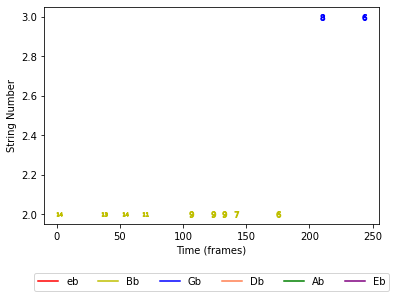

In [27]:
#code for generating the visual representation of the tabs

index = 0 #fill in a number here that corresponds to one of the songs

string1 = []
string2 = []
string3 = []
string4 = []
string5 = []
string6 = []

for i in predictions[index]:
    string1.append(i[0][0].tolist().index(max(i[0][0])))
    string2.append(i[0][1].tolist().index(max(i[0][1])))
    string3.append(i[0][2].tolist().index(max(i[0][2])))
    string4.append(i[0][3].tolist().index(max(i[0][3])))
    string5.append(i[0][4].tolist().index(max(i[0][4])))
    string6.append(i[0][5].tolist().index(max(i[0][5])))
strings = [string6,string5,string4,string3,string2,string1]

s = []
for j in strings:
    s6 = []
    prevtemp = 1
    temp = 1
    for i in range(len(j)):
        if i>0:
            if j[i] == j[i-1]:
                temp += 1
                if i == len(j)-1:
                    if j[i] != 0:
                        s6.append((prevtemp,j[i]))
                    prevtemp = temp
            else:
                if j[i-1] != 0:
                    s6.append((prevtemp, j[i-1]))
                prevtemp = temp
                temp += 1
                if i == len(j)-1:
                    if j[1] != 0:
                        s6.append((1,j[i]))
    s.append(s6)
    
strings = s

from matplotlib import lines as mlines, pyplot as plt

str_midi_dict = {0: 39, 1: 44, 2: 49, 3: 54, 4: 58, 5: 63}
string_dict = {5: 'Eb', 4: 'Ab', 3: 'Db', 2: 'Gb', 1: 'Bb', 0: 'eb'}
style_dict = {0 : 'r', 1 : 'y', 2 : 'b', 3 : '#FF7F50', 4 : 'g', 5 : '#800080'}
s = 0

handle_list = []

for string_tran in strings:
    handle_list.append(mlines.Line2D([], [], color=style_dict[s],
                                     label=string_dict[s]))
    for fret in string_tran:
        plt.scatter(fret[0], s+1, marker="${}$".format(fret[1]), color =
        style_dict[s])
#         start_time += 1
    s += 1

plt.xlabel('Time (frames)')
plt.ylabel('String Number')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
           handles=handle_list, ncol=8)